In [1]:
!pip install pandas
!pip install torch
!pip install nltk
!pip install tqdm
!pip install seaborn
!pip install numpy
!pip install sklearn

You should consider upgrading via the '/home/koteuka/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/koteuka/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/koteuka/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/koteuka/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/koteuka/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/koteuka/anaconda3/bin/python -m pip install --upgrade pip' command.
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1315 sha256=84673c9fa55cdb86f6763cf823d4a00999e765f2909ba966dbf362f3d4f3bc0c
  Stored in directory: /home/koteuka/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn
You should consider upgradi

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/koteuka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Скачиваем данные

In [3]:
!wget https://raw.githubusercontent.com/semensorokin/DLforNLP_course_material/master/Homework2/answers_subsample.csv

--2020-12-20 20:56:14--  https://raw.githubusercontent.com/semensorokin/DLforNLP_course_material/master/Homework2/answers_subsample.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.244.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.244.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28717126 (27M) [text/plain]
Saving to: ‘answers_subsample.csv’

answers_subsample.c 100%[===================>]  27,39M  7,73MB/s    in 3,7s    

2020-12-20 20:56:19 (7,39 MB/s) - ‘answers_subsample.csv’ saved [28717126/28717126]



In [4]:
# если ругается на то, что нет wget
# !apt-get install wget

In [5]:
!ls -l

total 28096
-rw-r--r-- 1 koteuka koteuka 28717126 дек 20 20:56 answers_subsample.csv
-rw-rw-r-- 1 koteuka koteuka    46187 дек 20 20:54 Копия_блокнота__QuesT_Homework3_classification_ipynb_.ipynb


In [6]:
import pandas as pd

In [7]:
data = pd.read_csv('answers_subsample.csv')

In [8]:
data

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон
...,...,...
237774,relax,елку нарядили? =)
237775,law,"Имеется переработка при 75% ставки, отгулы не ..."
237776,food,Попробовала варить рис с половиной кубика для ...
237777,food,Почему рекоменд... Почему рекомендуют есть фру...


In [9]:
data.category.value_counts() * 100 / data.shape[0]

law         29.793211
relax       22.016242
business    19.309527
food        18.367055
love        10.513965
Name: category, dtype: float64

# Предобученные эмбеддинги
[Источник](https://fasttext.cc/docs/en/crawl-vectors.html)  
Вы можете взять любые word2vec подобные эмббединги. Если вы хотите использовать elmo, bert, etc сначала попробуйте с word2vec подобными эмббедингами, а потом можете перейти к более сложным моделям.  
Ниже мы сначала скачиваем, а потом распоковываем эмбеддинги.

In [10]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
!gzip -d cc.ru.300.vec.gz

--2020-12-20 20:56:21--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1306357571 (1,2G) [binary/octet-stream]
Saving to: ‘cc.ru.300.vec.gz’

cc.ru.300.vec.gz    100%[===================>]   1,22G  9,30MB/s    in 2m 5s   

2020-12-20 20:58:28 (9,93 MB/s) - ‘cc.ru.300.vec.gz’ saved [1306357571/1306357571]



In [11]:
!ls -l

total 4458196
-rw-r--r-- 1 koteuka koteuka   28717126 дек 20 20:56 answers_subsample.csv
-rw-r--r-- 1 koteuka koteuka 4536408847 янв 18  2019 cc.ru.300.vec
-rw-rw-r-- 1 koteuka koteuka      53793 дек 20 20:57 Копия_блокнота__QuesT_Homework3_classification_ipynb_.ipynb


In [12]:
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from tqdm import tqdm

In [13]:

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/koteuka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
import string
from pymorphy2 import MorphAnalyzer
from razdel import tokenize
from nltk.corpus import stopwords
# потом можете добавить свою предобработку

morph = MorphAnalyzer()
stop = set(stopwords.words('russian'))


def process_text(text):
    text = str(text)
    text = text.replace("\n", " ")
    text = text.lower()
#     text = re.sub('\S*@\S*\s?', '', text)
#     text = re.sub('\s+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokenized_text = list(tokenize(text))
    lemm = [morph.parse(i.text)[0].normal_form for i in tokenized_text]
    words = [i for i in lemm if i not in stop and not i.isdigit() and len(i) > 2]
    return words
    # return " ".join(words)

In [15]:
word2freq = {}
lengths = []

for text in tqdm(data.text):
    
    words = process_text(text)
    
    lengths.append(len(words))
    
    for word in words:
        
        if word in word2freq:
            word2freq[word] += 1
        else:
            word2freq[word] = 1

100%|██████████| 237779/237779 [12:51<00:00, 308.15it/s]


In [16]:
import seaborn as sns
from matplotlib import pyplot as plt

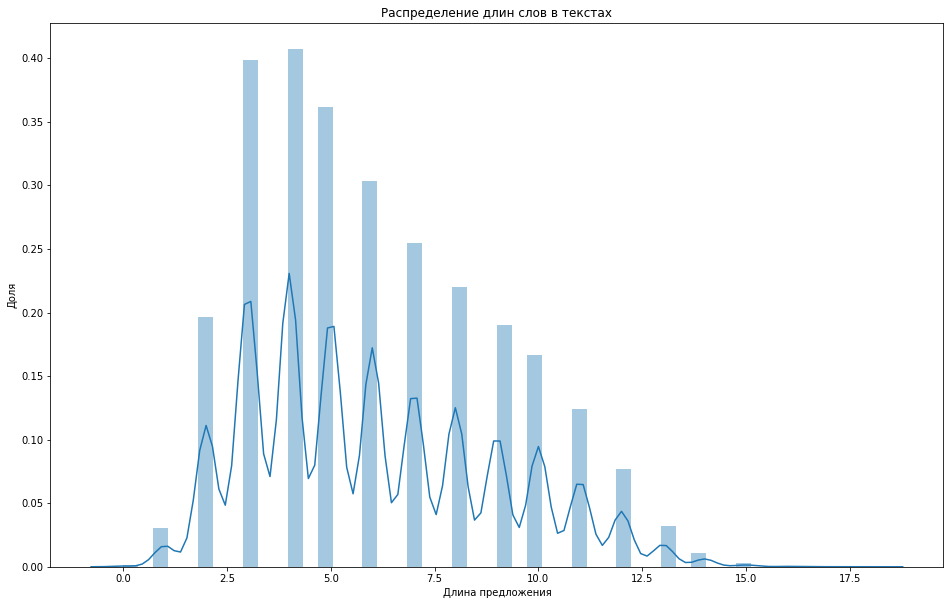

In [17]:
plt.figure(figsize=(16, 10))
plt.title('Распределение длин слов в текстах')
plt.xlabel('Длина предложения')
plt.ylabel('Доля')
sns.distplot(lengths)

In [18]:
upper_threshold = 32
lower_threshold = 3

correct_percent = len([sent_len for sent_len in lengths 
                       if sent_len <= upper_threshold and sent_len >= lower_threshold]) * 100 / len(lengths)

'{:.2f} % наших текстов входят в промежуток от {} до {} слов'.format(correct_percent, lower_threshold, upper_threshold)

'91.79 % наших текстов входят в промежуток от 3 до 32 слов'

In [19]:
len(word2freq)

79314

In [20]:
'{} слов, которые встречались 3 и менее раз'.format(len([word for word in word2freq if word2freq[word] <= 3]))

'60046 слов, которые встречались 3 и менее раз'

# Читаем файл с эмбеддингами
### Этот файл с 300 числами для 2 000 000 слов и он может не влезть в память
Поэтому прочитаем только те слова, которые мы знаем

In [21]:
import numpy as np

In [22]:
word2index = {'PAD': 0}
vectors = []
    
word2vec_file = open('cc.ru.300.vec')
    
n_words, embedding_dim = word2vec_file.readline().split()
n_words, embedding_dim = int(n_words), int(embedding_dim)

# Zero vector for PAD
vectors.append(np.zeros((1, embedding_dim)))

progress_bar = tqdm(desc='Read word2vec', total=n_words)

while True:

    line = word2vec_file.readline().strip()

    if not line:
        break
        
    current_parts = line.split()

    current_word = ' '.join(current_parts[:-embedding_dim])

    if current_word in word2freq:

        word2index[current_word] = len(word2index)

        current_vectors = current_parts[-embedding_dim:]
        current_vectors = np.array(list(map(float, current_vectors)))
        current_vectors = np.expand_dims(current_vectors, 0)

        vectors.append(current_vectors)

    progress_bar.update(1)

progress_bar.close()

word2vec_file.close()

vectors = np.concatenate(vectors)

Read word2vec: 100%|██████████| 2000000/2000000 [01:19<00:00, 25247.14it/s]


In [23]:
len(word2index)

42780

In [24]:
unk_words = [word for word in word2freq if word not in word2index]
unk_counts = [word2freq[word] for word in unk_words]
n_unk = sum(unk_counts) * 100 / sum(list(word2freq.values()))

sub_sample_unk_words = {word: word2freq[word] for word in unk_words}
sorted_unk_words = list(sorted(sub_sample_unk_words, key=lambda x: sub_sample_unk_words[x], reverse=True))

print('Мы не знаем {:.2f} % слов в датасете'.format(n_unk))
print('Количество неизвестных слов {} из {}, то есть {:.2f} % уникальных слов в словаре'.format(
    len(unk_words), len(word2freq), len(unk_words) * 100 / len(word2freq)))
print('В среднем каждое встречается {:.2f} раз'.format(np.mean(unk_counts)))
print()
print('Топ 5 невошедших слов:')

for i in range(5):
    print(sorted_unk_words[i], 'с количеством вхождениий -', word2freq[sorted_unk_words[i]])

Мы не знаем 3.94 % слов в датасете
Количество неизвестных слов 36535 из 79314, то есть 46.06 % уникальных слов в словаре
В среднем каждое встречается 1.54 раз

Топ 5 невошедших слов:
нибыть с количеством вхождениий - 1254
чтоть с количеством вхождениий - 746
ктонибыть с количеством вхождениий - 568
исковый с количеством вхождениий - 248
ктоть с количеством вхождениий - 227


# Потеря 2.5 % слов в датасете
Эта ситуация не то, чтобы сильно плохая, в учебных целях нормально, к тому же в среднем они редко встречаются. Вы можете поиграть с предобработкой.

In [25]:
import torch

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [26]:
x = torch.rand(128, 64, 1024)

In [27]:
lstm = torch.nn.LSTM(1024, 512, batch_first=True)

In [28]:
%%timeit

pred = lstm(x)

378 ms ± 35.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# А что GPU?

In [29]:
print('Доступна ли видеокарта:', torch.cuda.is_available())
print('Если недоступна, поменяйте runtime, если в колабе')

Доступна ли видеокарта: True
Если недоступна, поменяйте runtime, если в колабе


In [30]:
# универсальных способ задать device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# если доступна gpu, то давайте ее использовать, но в этом задании должны использовать

In [31]:
# перенесли x на gpu
x_gpu = x.to(device)

In [32]:
# зададим lstm на gpu
lstm_gpu = torch.nn.LSTM(1024, 512, batch_first=True)
lstm_gpu = lstm_gpu.to(device)

In [33]:
%%timeit

pred = lstm_gpu(x_gpu)

12.2 ms ± 65.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# У меня на 1070 TI скорость уменьшилась с 381мс до 41мс, то есть в 9.29 раз

In [34]:
# если у нас модель на гпу, а то, что мы туда подаем нет, то работать не будет
# справедлива и обратная ситуация

# выскочит ошибка
# посмотрите на нее, возможно, вы еще встретитесь
# pred = lstm_gpu(x)

# Важные и не очень интуитивные моменты про LSTM и CNN в торче

По умолчанию LSTM принимает данные с такой размерностью:
```python
(seq_len, batch, input_size)
```
Сделано это с целью оптимизации на более низком уровне.  
Мы оперируем такими объектами:
```python
(batch, seq_len, input_size)
```
Чтобы LSTM у нас заработала правильно, мы можем либо передать параметр ```batch_first=True``` во время инициализации слоя,
либо транспонировать (поменять) первую и вторую размерность у нашего x перед подачей в слой.  
[Подробнее про LSTM](https://pytorch.org/docs/stable/nn.html#lstm)

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [35]:
# первый способ
lstm = torch.nn.LSTM(1024, 512, batch_first=True)

pred, mem = lstm(x)

In [36]:
pred.shape

torch.Size([128, 64, 512])

In [37]:
lstm = torch.nn.LSTM(1024, 512)

# меняем размерность batch и seq_len местами
x_transposed = x.transpose(0, 1)
pred_transposed, mem = lstm(x_transposed)

In [38]:
# у нас все еще осталась размерность (seq_len, batch, input_size)
pred_transposed.shape

torch.Size([64, 128, 512])

In [39]:
# просто транспонируем еще раз
pred = pred_transposed.transpose(0, 1)
pred.shape

torch.Size([128, 64, 512])

## Conv1d & MaxPool1d
Примерно такая же ситуация происходит со сверточными слоями и пулингами.  
1d реализация как раз для текстов, в ней матрица-фильтр ходит только по одной размерности.  
[Подробнее про CNN](https://pytorch.org/docs/stable/nn.html#conv1d)  
[Подробнее про пулинг](https://pytorch.org/docs/stable/nn.html#maxpool1d)  
Ожидается такая размерность:
```python
(batch, input_size, seq_len)
```
Мы все еще хоти подавать такую размерность:
```python
(batch, seq_len, input_size)
```
В случае со свертками и пулингами у нас есть вариант только транспонировать x перед подачей и транспонировать полученный результат. Обратите внимание, что транспонируем мы первую и вторую размерность (индексация с нуля).

In [40]:
x.shape

torch.Size([128, 64, 1024])

- 128 - размер батча
- 64 - количество слов
- 1024 - эмбеддинг слова

In [41]:
# in_channels - размер входных эмбеддингов
# out_channels - количество/какой размер эмбеддингов мы хотим получить
# kernel_size - размер окна/н-граммы
cnn = torch.nn.Conv1d(in_channels=1024, out_channels=512, kernel_size=3)

In [42]:
# выпадет ошибка, посмотрите какая
# pred = cnn(x)

In [43]:
x_transposed = x.transpose(1, 2)
x_transposed.shape
# перевели в (batch, input_size, seq_len)

torch.Size([128, 1024, 64])

In [44]:
pred_transposed = cnn(x_transposed)
pred_transposed.shape
# осталась разрмерность (batch, output_size, seq_len)

torch.Size([128, 512, 62])

In [45]:
# переведем обратно в (batch, seq_len, input_size)
pred = pred_transposed.transpose(1, 2)
pred.shape

torch.Size([128, 62, 512])

# Подготовим данные в DataLoader

In [46]:
from torch.utils.data import Dataset, DataLoader

In [47]:
'UNK' in word2index

False

In [48]:
data.head()

,category,text
0,business,Могут ли в россельхозбанке дать в залог норков...
1,law,Может ли срочник перевестись на контракт после...
2,business,Продажа недвижимости по ипотеки ? ( арестованы...
3,business,"В чем смысл криптовалюты, какая от неё выгода ..."
4,law,часть 1 статья 158 похитил телефон


# Замапим категории в индексы

In [49]:
cat_mapper = {cat: n for n, cat in enumerate(data.category.unique())}

In [50]:
cat_mapper

{'business': 0, 'law': 1, 'love': 2, 'relax': 3, 'food': 4}

In [51]:
data.category = data.category.map(cat_mapper)

# Читалка данных

## Что происходит ниже
1. Мы задаем x_data, y_data (таргеты), word2index (маппер из слова в индекс слова), sequence_length (максимальная длина последовательности, если больше, ограничить ею), pad_token (токен паддинга и задаем его индекс pad_index).
1. Загружаем данные:
    1. Проходимся по датасету
    1. Предобрабатываем каждый текст в датасете
    1. Индексируем его
    1. Паддим до нужной длины
1. Когда нам нужно достать пример из датасета мы берем индексированный ```x``` и соответствующий этому индексу ```y```, наш ```x``` также паддим (или ограничиваем длину) и переводим в ```torch.Tensor(x).long()```. Для ```y``` этого делать не потребуется, в dataloader'е таргеты преобразуются в тензор сами.


In [58]:
class WordData(Dataset):
    
    def __init__(self, x_data, y_data, word2index, sequence_length=32, pad_token='PAD', verbose=True):
        
        super().__init__()
        
        self.x_data = []
        self.y_data = y_data
        
        self.word2index = word2index
        self.sequence_length = sequence_length
        
        self.pad_token = pad_token
        self.pad_index = self.word2index[self.pad_token]
        
        self.load(x_data, verbose=verbose)
        
    @staticmethod
    def process_text(text):
        text = str(text)
        text = text.replace("\n", " ")
        text = text.lower()
    #     text = re.sub('\S*@\S*\s?', '', text)
    #     text = re.sub('\s+', ' ', text)
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokenized_text = list(tokenize(text))
        lemm = [morph.parse(i.text)[0].normal_form for i in tokenized_text]
        words = [i for i in lemm if i not in stop and not i.isdigit() and len(i) > 2]
        return words
        
    def load(self, data, verbose=True):
        
        data_iterator = tqdm(data, desc='Loading data', disable=not verbose)
        
        for text in data_iterator:
            
            words = self.process_text(text)
            
            indexed_words = self.indexing(words)
            
            self.x_data.append(indexed_words)
    
    def indexing(self, tokenized_text):

        # здесь мы не используем токен UNK, потому что мы его специально не учили
        # становится непонятно какой же эмбеддинг присвоить неизвестному слову,
        # поэтому просто выбрасываем наши неизветсные слова
        
        return [self.word2index[word] for word in tokenized_text if word in self.word2index]
    
    def padding(self, sequence):
        
        # Ограничить длину self.sequence_length
        # если длина меньше максимально - западить
        if len(sequence)< self.sequence_length:
            add_pad = self.sequence_length - len(sequence)
            return sequence+[self.pad_index]*add_pad
        else:
            return sequence[:self.sequence_length]
    
    def __len__(self):
        
        return len(self.x_data)
    
    def __getitem__(self, idx):
        
        x = self.x_data[idx]
        x = self.padding(x)
        x = torch.Tensor(x).long()
        
        y = self.y_data[idx]
        
        return x, y

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [60]:
x_train, x_validation, y_train, y_validation = train_test_split(data.text, data.category, test_size=0.1)

train_dataset = WordData(list(x_train), list(y_train), word2index)
train_loader = DataLoader(train_dataset, batch_size=64)

validation_dataset = WordData(list(x_validation), list(y_validation), word2index)
validation_loader = DataLoader(validation_dataset, batch_size=64)

Loading data: 100%|██████████| 23778/23778 [01:16<00:00, 308.86it/s]


In [64]:
for x, y in train_loader:
    break

In [65]:
x

tensor([[ 1526,  1406,    12,  ...,     0,     0,     0],
        [  234, 23596,  4570,  ...,     0,     0,     0],
        [ 5702,    88,   212,  ...,     0,     0,     0],
        ...,
        [  860,  2212,     6,  ...,     0,     0,     0],
        [  113,   408,   159,  ...,     0,     0,     0],
        [ 1462, 13796, 13326,  ...,     0,     0,     0]])

In [66]:
y

tensor([4, 1, 1, 3, 0, 1, 1, 3, 1, 4, 2, 0, 4, 4, 2, 4, 1, 4, 4, 3, 3, 2, 3, 1,
        3, 0, 1, 3, 4, 4, 3, 0, 2, 3, 0, 0, 1, 3, 2, 4, 1, 0, 3, 1, 1, 1, 0, 1,
        1, 4, 1, 4, 3, 4, 4, 0, 4, 4, 3, 1, 1, 1, 2, 1])

# Обучить нейронку

In [193]:
from math import sqrt

class model_with_att(torch.nn.Module):
    def __init__(self, matrix_w, n): #n - количетсво категорий
        
        super().__init__()

        self.n = n

        self.emb_layer = torch.nn.Embedding.from_pretrained(torch.Tensor(matrix_w))

        self.LSTM = torch.nn.LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)

        self.q_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True)
        self.k_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True)
        self.v_proj = torch.nn.Linear(in_features=512, out_features=256, bias=True)

        self.att_soft = torch.nn.Softmax(dim = 2)

        self.cnn_3gr = torch.nn.Conv1d(256, 128, kernel_size=(3,), stride=(1,))
        self.cnn_4gr = torch.nn.Conv1d(256, 128, kernel_size=(4,), stride=(1,))
        self.cnn_5gr = torch.nn.Conv1d(256, 128, kernel_size=(5,), stride=(1,))

        self.linear_1 = torch.nn.Linear(in_features=384, out_features=256, bias=True) # сверху накидываем два полносвязных слоя для классификации
        self.relu = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=256, out_features=n, bias=True)

        
    def forward(self, x):
        x_emb = self.emb_layer(x) #примените эмбеддинги
        # транспонируйте тензор для лстм как было описано выше
        x_emb = x_emb.transpose(0, 1)
        x, _ = self.LSTM(x_emb) # применим лстм, не забываем что на выходе у него много всяких последовательностей, нам нужна только эта
        # транспонируйте обратно
        x = x.transpose(0, 1)

        x_q = self.q_proj(x) #применим линейные преобразования для селф-эттеншена
        x_k = self.k_proj(x)
        x_v = self.v_proj(x)

        att_scores = torch.bmm(x_q, x_k.transpose(1, 2)) / np.sqrt(x_q.shape[-1])
        # посмотрите в презентацию и перемножьте нужные тензора изспольуя функцию bmm из торча, перед этим одну из матриц обзательно транспонируйте
        # результат обязательно поделите на корень из последней размерности (то есть на рземер эмбеддинга из предыдущего слоя)
        att_dist = self.att_soft(att_scores) # накидываем софтмакс
        
#         print("x_v.transpose(1, 2).shape: ", x_v.transpose(1, 2).shape)
#         print("att_dist.shape: ", att_dist.shape)
        
        attention_vectors = torch.bmm(att_dist, x_v)# тут тоже что то с чем то нужно перемножить :)
#         print(attention_vectors.shape)
        
        x_att = attention_vectors.transpose(2,1) #транспонируем для конфолючионнах фильтров
#         print(x_att.shape)
        
        x_cnn3 = self.cnn_3gr(x_att)
        x_cnn4 = self.cnn_4gr(x_att)
        x_cnn5 = self.cnn_5gr(x_att)

        frst, _ =  x_cnn3.max(dim= -1,) # cделаем макс пуллинг
        sc, _ = x_cnn4.max(dim= -1,)
        thr, _ = x_cnn5.max(dim= -1,)

        x_cat = torch.cat((frst, sc, thr), dim=-1) # а теперь объединим результаты

        x = self.linear_1(x_cat)# пару полносвязных слоев с релу для классификации
        x = self.relu(x)    
        x = self.linear_2(x)

        return x

In [194]:
n_classes = data.category.unique().shape[0]

In [195]:
model = model_with_att(vectors, n_classes)

In [196]:
model #если сделать batch_first=True, то можно не транспонировать батчи

model_with_att(
  (emb_layer): Embedding(42780, 300)
  (LSTM): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (q_proj): Linear(in_features=512, out_features=256, bias=True)
  (k_proj): Linear(in_features=512, out_features=256, bias=True)
  (v_proj): Linear(in_features=512, out_features=256, bias=True)
  (att_soft): Softmax(dim=2)
  (cnn_3gr): Conv1d(256, 128, kernel_size=(3,), stride=(1,))
  (cnn_4gr): Conv1d(256, 128, kernel_size=(4,), stride=(1,))
  (cnn_5gr): Conv1d(256, 128, kernel_size=(5,), stride=(1,))
  (linear_1): Linear(in_features=384, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=5, bias=True)
)

In [197]:
with torch.no_grad():
    pred = model(x)

In [198]:
pred.shape

torch.Size([64, 5])

In [204]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [205]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model = model.to(device)
criterion = criterion.to(device)

In [208]:
epochs = 4
losses = []
best_test_loss = 10.

test_f1 = []

for n_epoch in range(epochs):
    
    train_losses = []
    test_losses = []
    test_targets = []
    test_pred_class = []
    
    progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))
    
    model.train()
    
    for x, y in train_loader:

        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        pred = model(x)
        loss = criterion(pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        train_losses.append(loss.item())
        losses.append(loss.item())
        
        progress_bar.set_postfix(train_loss = np.mean(losses[-500:]))

        progress_bar.update(x.shape[0])
        
    progress_bar.close()
    
    model.eval()
    
    for x, y in validation_loader:
        
        x = x.to(device)

        with torch.no_grad():

            pred = model(x)

            pred = pred.cpu()

            test_targets.append(y.numpy())
            test_pred_class.append(np.argmax(pred, axis=1))

            loss = criterion(pred, y)

            test_losses.append(loss.item())
        
    mean_test_loss = np.mean(test_losses)

    test_targets = np.concatenate(test_targets).squeeze()
    test_pred_class = np.concatenate(test_pred_class).squeeze()

    f1 = f1_score(test_targets, test_pred_class, average='micro')

    test_f1.append(f1)
    
    print()
    print('Losses: train - {:.3f}, test - {:.3f}'.format(np.mean(train_losses), mean_test_loss))

    print('F1 test - {:.3f}'.format(f1))
        
    # Early stopping:
    if mean_test_loss < best_test_loss:
        best_test_loss = mean_test_loss
    else:
        print('Early stopping')
        break

Epoch 2:   0%|          | 192/214001 [00:00<02:39, 1343.31it/s, train_loss=0.514]


Losses: train - 0.543, test - 0.520
F1 test - 0.813


Epoch 3:   0%|          | 192/214001 [00:00<02:36, 1370.33it/s, train_loss=0.487]


Losses: train - 0.501, test - 0.503
F1 test - 0.818


Epoch 4:   0%|          | 192/214001 [00:00<02:47, 1275.94it/s, train_loss=0.468]


Losses: train - 0.480, test - 0.491
F1 test - 0.823


Epoch 4: 100%|██████████| 214001/214001 [02:42<00:00, 1319.34it/s, train_loss=0.452]



Losses: train - 0.461, test - 0.492
F1 test - 0.825
Early stopping


Если вы запускаете много раз колаб окна и ткдм начинает беситься, можно запустить окно ниже, ткдм обновится и все снова станет хорошо

In [207]:
for instance in list(tqdm._instances): 
    tqdm._decr_instances(instance)